In [1]:
!pip install opencv-contrib-python==4.1.0.25
!pip install fuzzywuzzy[speedup]
!pip install torch torchvision

In [2]:
!rm -rf ba_dataset
!git clone https://github.com/korayakan/ba_dataset.git

Cloning into 'ba_dataset'...
remote: Enumerating objects: 2643, done.
remote: Counting objects: 100% (2643/2643), done.
remote: Compressing objects: 100% (2589/2589), done.
remote: Total 2643 (delta 52), reused 2639 (delta 51), pack-reused 0
Receiving objects: 100% (2643/2643), 448.27 MiB | 33.52 MiB/s, done.
Resolving deltas: 100% (52/52), done.
Checking out files: 100% (4228/4228), done.


In [3]:
import numpy
numpy.__version__

'1.16.4'

In [4]:
import matplotlib
matplotlib.__version__

'3.0.3'

In [5]:
import cv2
cv2.__version__

'4.1.0'

In [6]:
import torch
torch.__version__

'1.1.0'

In [0]:
# for plotting
import matplotlib.pyplot as plt

# for json
import json

# for fuzzy string compariosn
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# for encoding strings
from zlib import crc32

# for glob file search
import glob

In [8]:
x=torch.rand(5, 3)
print(x)

tensor([[0.9036, 0.5011, 0.9429],
        [0.2604, 0.1428, 0.8123],
        [0.9320, 0.4013, 0.5270],
        [0.3096, 0.9153, 0.6187],
        [0.4508, 0.9545, 0.0257]])


In [0]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # to specify the GPU_id in the remote server

from torchvision import transforms
#from utils import *
from PIL import Image, ImageDraw, ImageFont
#from create_data_lists import *
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # to specify the GPU_id in the remote server

import time
import torch.backends.cudnn as cudnn
import torch
import torch.optim
import torch.nn
import torch.utils.data
#from model import LSTMClassifier
#from datasets import ICDARDataset #, PadSequence
#from utils import *
import numpy as np
#from focalloss import *
#from create_data_lists import parse_annotation
#from train import val_accuracy

In [0]:
def get_filenames(path, suffix):
    path=path + '/' if not path.endswith('/') else path
    files=glob.glob(path + '*.' + suffix)
    for idx, file in enumerate(files):
        files[idx]=file.split("/")[-1].replace('.txt', '')
    return files

def get_text_filenames(path):
    return get_filenames(path, 'txt')

def get_image_filenames(path):
    return get_filenames(path, 'jpg')

def read_text_file(path, filename):
    path=path + '/' if not path.endswith('/') else path
    text=''
    with open(path + filename + '.txt') as file:
        text=file.read()
    return text

def read_text_file_lines(path, filename):
    path=path + '/' if not path.endswith('/') else path
    lines=[]
    with open(path + filename + '.txt') as file:
        for line in file:
            lines.append(line.rstrip('\n'))
    return lines

def read_coordinates(path, filename):
    text=read_text_file_lines(position_path, test)
    coordinates=[]
    for line in text:
        tokens=line.split(',')
        line_coordinates=list(map(int, tokens[0:8]))
        line_text=','.join(tokens[8:])
        line_coordinates.append(line_text)
        coordinates.append(line_coordinates)
    return coordinates

def read_normalized_coordinates(path, filename, height, width):
    coordinates=read_coordinates(path, filename)
    for line in coordinates:
        for x in range(0,8,2):
            line[x]/=width
        for x in range(1,8,2):
            line[x]/=height
        line.append(line[8])
        line[8]=normalize_text(line[8])
    return coordinates

def read_image_file(path, filename):
    path=path + '/' if not path.endswith('/') else path
    img=cv2.imread(path + filename + '.jpg', 0)
    return img

def show_image(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

def match_category(text, categories, categories_reverted):
    category_values=list(categories.values())
    category_guess=process.extractOne(text, category_values, scorer=fuzz.partial_ratio, score_cutoff=90)
    category=''
    if category_guess is not None:
        category=categories_reverted[category_guess[0]]
    return [category, encode_category(category)]

def encode_category(category):
    encoded=[]
    if category == 'company':
        encoded=[1,0,0,0]
    elif category == 'date':
        encoded=[0,1,0,0]
    elif category == 'address':
        encoded=[0,0,1,0]
    elif category == 'total':
        encoded=[0,0,0,1]
    else:
        encoded=[0,0,0,0]
    return encoded

def normalize_text(input, encoding="utf-8"):
    # see https://stackoverflow.com/questions/40351791/how-to-hash-strings-into-a-float-in-01
    return float(crc32(input.encode(encoding)) & 0xffffffff) / 2**32

In [0]:
position_path='ba_dataset/SROIE2019/0325updated.task1train(626p)'
category_path='ba_dataset/SROIE2019/0325updated.task2train(626p)'
img_path=position_path

In [12]:
image_files=get_text_filenames(img_path)
print('found {} image files'.format(len(image_files)))

found 835 image files


In [13]:
position_files=get_text_filenames(position_path)
print('found {} files with position data'.format(len(position_files)))

found 835 files with position data


In [14]:
category_files=get_text_filenames(category_path)
print('found {} files with category data'.format(len(category_files)))

found 876 files with category data


In [15]:
filenames=list(set(image_files) & set(position_files) & set(category_files))
filenames.sort()
print('found {} files with position and category data'.format(len(filenames)))

found 716 files with position and category data


In [0]:
test=filenames[0]

file X00016469612
1013 x 463 pixels


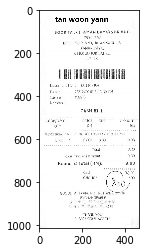

categories:
{
    "company": "BOOK TA .K (TAMAN DAYA) SDN BHD",
    "date": "25/12/2018",
    "address": "NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.",
    "total": "9.00"
} 

positions:
[0.15550755939524838, 0.024679170779861797, 0.7041036717062635, 0.024679170779861797, 0.7041036717062635, 0.0631786771964462, 0.15550755939524838, 0.0631786771964462, 0.2441371357999742, 'TAN WOON YANN'] ['', [0, 0, 0, 0]]
[0.1079913606911447, 0.08094768015794669, 0.9503239740820735, 0.08094768015794669, 0.9503239740820735, 0.1194471865745311, 0.1079913606911447, 0.1194471865745311, 0.7220568691845983, 'BOOK TA .K(TAMAN DAYA) SDN BND'] ['company', [1, 0, 0, 0]]
[0.4427645788336933, 0.1194471865745311, 0.6155507559395248, 0.1194471865745311, 0.6155507559395248, 0.1372161895360316, 0.4427645788336933, 0.1372161895360316, 0.7300541666336358, '789417-W'] ['', [0, 0, 0, 0]]
[0.23758099352051837, 0.14215202369200394, 0.8272138228941684, 0.14215202369200394, 0.8272138228941684, 0.16

In [17]:
print('file {}'.format(test))
img=read_image_file(img_path, test)
height, width=img.shape[:2]
print(str(height) + ' x ' + str(width) + ' pixels')
show_image(img)
print('categories:')
text=read_text_file(category_path, test)
print(text, '\n')

categories=json.loads(text)
categories_reverted={v: k for k, v in categories.items()}

print('positions:')
coordinates=read_normalized_coordinates(position_path, test, height, width)
for coordinate in coordinates:
    coordinate_text=coordinate[9]
    category=match_category(coordinate_text, categories, categories_reverted)
    print(coordinate, category)